In [1]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import os
from skimage.draw import polygon

Part 1 -- Defining Correspondences

In [237]:
with open('keypoints.json', 'r') as f:
    keypoints = json.load(f)

# Extract keypoints
im1_points = np.array(keypoints['im1Points'])
im2_points = np.array(keypoints['im2Points'])

corner_points = np.array([[0, 0], [600, 0], [0, 750], [600, 750]])

im1_points = np.vstack([im1_points, corner_points])
im2_points = np.vstack([im2_points, corner_points])

# Load images
im1 = cv2.imread('me.jpg')
im2 = cv2.imread('zuckerberg.jpg')

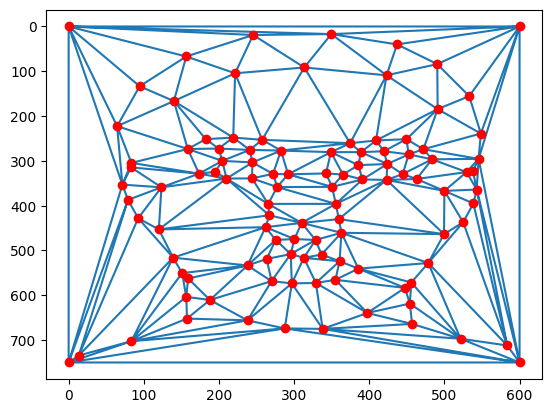

In [238]:
# Compute the Delaunay triangulation on the average face
average_points = (im1_points + im2_points) / 2

tri = Delaunay(average_points)

plt.triplot(average_points[:, 0], average_points[:, 1], tri.simplices)
plt.scatter(average_points[:, 0], average_points[:, 1], color='red')
plt.gca().invert_yaxis()
plt.show()


Part 2 -- Computing the "Mid-Way" Face

In [8]:
def computeAffine(dst_pts, src_pts):
    # Prepare the matrix to solve
    A = np.array([
        [dst_pts[0][0], dst_pts[0][1], 1, 0, 0, 0],
        [0, 0, 0, dst_pts[0][0], dst_pts[0][1], 1],
        [dst_pts[1][0], dst_pts[1][1], 1, 0, 0, 0],
        [0, 0, 0, dst_pts[1][0], dst_pts[1][1], 1],
        [dst_pts[2][0], dst_pts[2][1], 1, 0, 0, 0],
        [0, 0, 0, dst_pts[2][0], dst_pts[2][1], 1],
    ])
    B = np.array([
        src_pts[0][0], src_pts[0][1],
        src_pts[1][0], src_pts[1][1],
        src_pts[2][0], src_pts[2][1]
    ])
    
    # Find a, b, c, d, e, f
    affine_params = np.linalg.solve(A, B)

    # Reshape
    affine_matrix = affine_params.reshape(2, 3)
    
    return affine_matrix


In [9]:
#Interpolation

def interpolate_color(image, point):
    x, y = point[0], point[1]
    
    x0, y0 = int(np.floor(x)), int(np.floor(y))
    x1, y1 = min(x0 + 1, image.shape[1] - 1), min(y0 + 1, image.shape[0] - 1)
    
    dx, dy = x - x0, y - y0
    
    p00 = image[y0, x0]
    p01 = image[y1, x0]
    p10 = image[y0, x1]
    p11 = image[y1, x1]
    
    interpolated_color = (1 - dx) * (1 - dy) * p00 + dx * (1 - dy) * p10 + (1 - dx) * dy * p01 + dx * dy * p11
    
    return interpolated_color

In [10]:
def inverse_warp(dst_tri, src_tri, src_image, rr, cc):
    affine_matrix = computeAffine(dst_tri, src_tri)
    linear_part = affine_matrix[:, :2]
    translation = affine_matrix[:, 2]
    
    # Create homogeneous coordinates
    dst_pts = np.vstack((cc, rr)).T
    ones = np.ones((dst_pts.shape[0], 1))
    dst_pts_hom = np.hstack([dst_pts, ones])
    
    # Compute source points
    src_pts = dst_pts_hom.dot(affine_matrix.T)
    
    # Compute warped triangle colors
    warped_triangle = np.zeros((rr.shape[0], 3), dtype=np.float32)
    
    for i in range(rr.shape[0]):
        src_pt = src_pts[i]
        if 0 <= src_pt[0] < src_image.shape[1] and 0 <= src_pt[1] < src_image.shape[0]:
            warped_triangle[i] = interpolate_color(src_image, src_pt)
    
    return warped_triangle


In [11]:
#Combine functions defined previously
def warp_triangle(src_img, src_tri, dst_tri, midway_face, rr, cc):
    affine_matrix = computeAffine(src_tri, dst_tri)

    warped_triangle = inverse_warp(affine_matrix, dst_tri, src_img, rr, cc)

    return warped_triangle

In [12]:
def morph_faces(im1, im2, points1, points2, avg_points, tri, warp_frac=0.5, dissolve_frac=0.5, expansion_amount=2):
    height, width, channels = im1.shape
    morphed_face = np.zeros((height, width, channels), dtype=np.float32)

    if warp_frac != 0.5 or dissolve_frac != 0.5:
        intermediate_points = (1 - warp_frac) * points1 + warp_frac * points2
    else:
        intermediate_points = avg_points  # Use passed in avg_points for mid-way face

    for triangle in tri.simplices:
        # Get triangle points in both images and the intermediate
        t1 = points1[triangle]
        t2 = points2[triangle]
        t_intermediate = intermediate_points[triangle]

        # Compute the centroid (Referenced method on Ed)
        centroid = np.mean(t_intermediate, axis=0)

        # Expand the vertices of the intermediate triangle
        expanded_t_intermediate = []
        for vertex in t_intermediate:
            direction = vertex - centroid
            norm = np.linalg.norm(direction)
            if norm != 0:
                normalized_direction = direction / norm
            else:
                normalized_direction = np.zeros_like(direction)
            expanded_vertex = vertex + normalized_direction * expansion_amount
            expanded_t_intermediate.append(expanded_vertex)

        expanded_t_intermediate = np.array(expanded_t_intermediate)

        # Use skimage.draw.polygon to get the mask
        rr, cc = polygon(expanded_t_intermediate[:, 1], expanded_t_intermediate[:, 0], (height, width))

        # Warp triangles from both images to the intermediate shape
        warped_t1 = inverse_warp(t_intermediate, t1, im1, rr, cc)
        warped_t2 = inverse_warp(t_intermediate, t2, im2, rr, cc)

        # Blend
        blended_triangle = (1 - dissolve_frac) * warped_t1 + dissolve_frac * warped_t2

        # Fill the triangle
        morphed_face[rr, cc] = blended_triangle
    morphed_face = np.clip(morphed_face, 0, 255).astype(np.uint8)

    return morphed_face


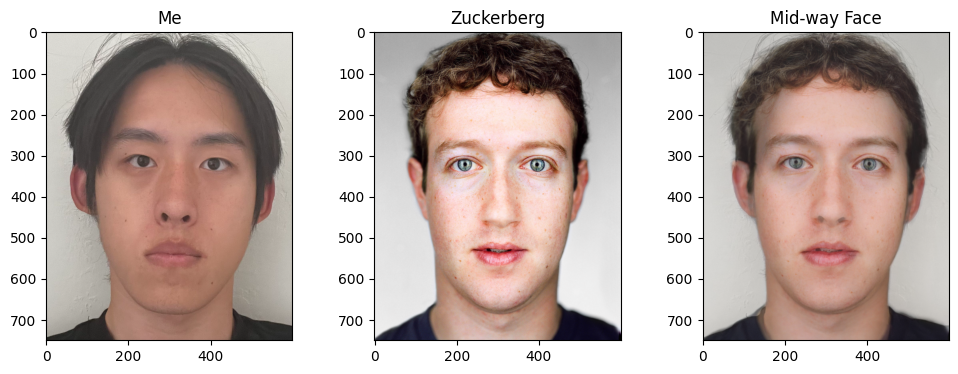

In [244]:
#Display midway face
midway_face = morph_faces(im1, im2, im1_points, im2_points, average_points, tri)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
plt.title('Me')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
plt.title('Zuckerberg')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(midway_face, cv2.COLOR_BGR2RGB))
plt.title('Mid-way Face')

plt.show()

Part 3 -- Morph Sequence

In [249]:
import imageio

num_frames = 45
frames = []

for i in range(num_frames):
    frac = i / (num_frames - 1)

    # Compute intermediate points based on warp_frac
    intermediate_points = (1 - frac) * im1_points + frac * im2_points

    # Compute triangulation
    tri = Delaunay(intermediate_points)

    morphed_im = morph_faces(im1, im2, im1_points, im2_points, intermediate_points, tri, warp_frac=frac, dissolve_frac=frac)

    frames.append(cv2.cvtColor(morphed_im, cv2.COLOR_BGR2RGB))

imageio.mimsave('morph_sequence.gif', frames, fps=10)


Part 4 -- The "Mean Face" of a Population

In [3]:
def read_pts_file(pts_file_path):
    with open(pts_file_path, 'r') as f:
        lines = f.readlines()

    n_points_line = [line for line in lines if 'n_points' in line][0]
    n_points = int(n_points_line.strip().split(':')[1])

    start_idx = lines.index('{\n') + 1
    end_idx = start_idx + n_points

    points = []
    for line in lines[start_idx:end_idx]:
        x_str, y_str = line.strip().split()
        x, y = float(x_str), float(y_str)
        points.append([x, y])

    points.extend([[0, 0], [250, 0], [0, 300], [250, 300]])

    return np.array(points)


In [4]:
dataset_path = 'FEI_frontal'

images = []
all_points = []

# Loop over the images and corresponding .pts files
for i in range(1, 101):
    image_name = f'{i}a.jpg'
    pts_name = f'{i}a.pts'
    image_path = os.path.join(dataset_path, image_name)
    pts_path = os.path.join(dataset_path, pts_name)

    # Read the image
    img = cv2.imread(image_path)
    points = read_pts_file(pts_path)

    # Append to the lists
    images.append(img)
    all_points.append(points)


In [5]:
# Get mean shape
all_points_array = np.array(all_points)

mean_shape = np.mean(all_points_array, axis=0)

mean_shape_int = mean_shape.astype(np.int32)


In [6]:
def warp_to_average_shape(img, img_points, mean_shape):

    tri = Delaunay(mean_shape)
    height, width = img.shape[:2]
    warped_img = np.zeros_like(img, dtype=np.float32)
    for triangle in tri.simplices:
        t_in = img_points[triangle]
        t_mean = mean_shape[triangle]
        rr, cc = polygon(t_mean[:, 1], t_mean[:, 0], (height, width))
        if len(rr) == 0:
            continue
        colors = inverse_warp(t_mean, t_in, img, rr, cc)
        warped_img[rr, cc] = colors
    warped_img = np.clip(warped_img, 0, 255).astype(np.uint8)
    return warped_img


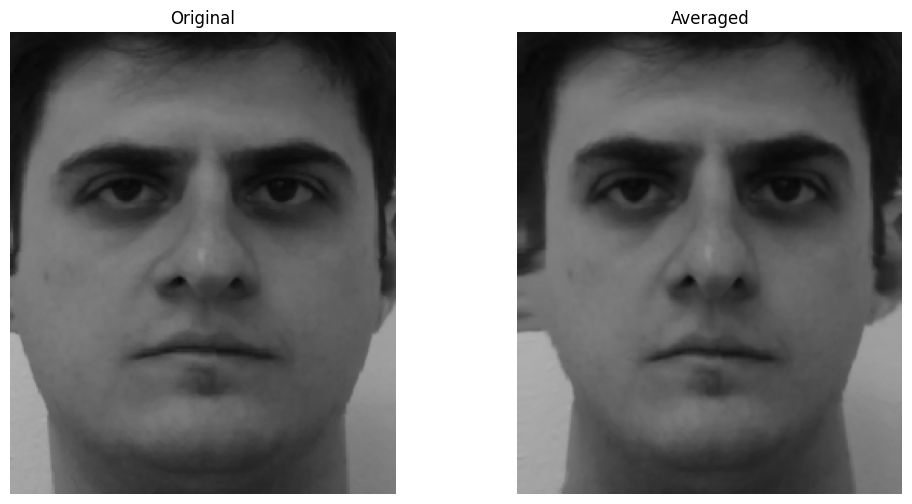

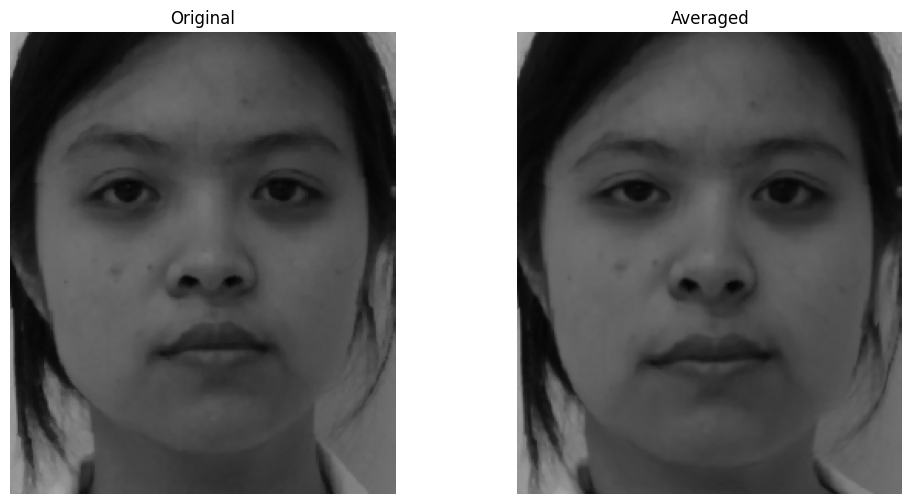

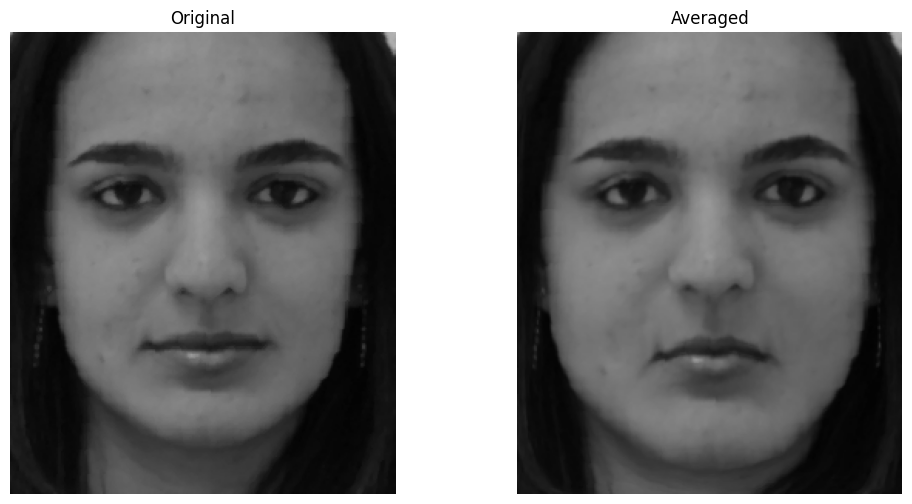

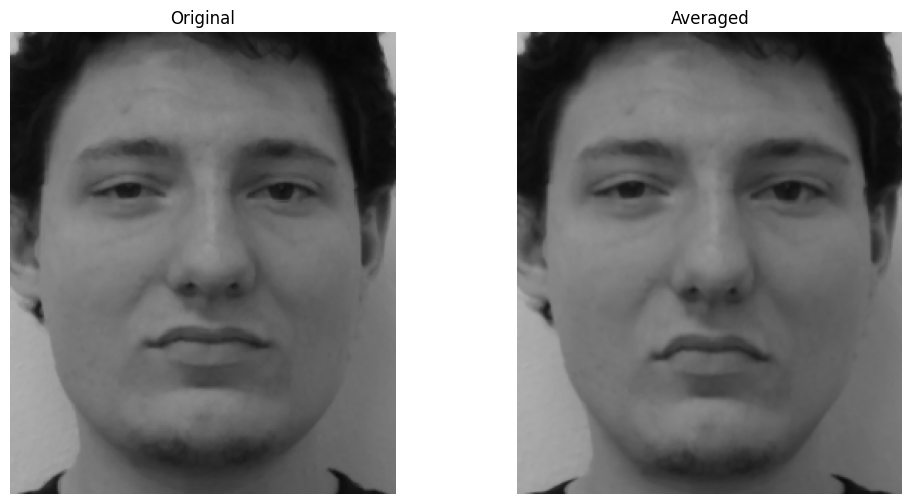

In [13]:
warped_images = []

for idx, img in enumerate(images):
    img_points = all_points[idx]
    warped_img = warp_to_average_shape(img, img_points, mean_shape)
    warped_images.append(warped_img)
    
    # Display some examples
    if idx % 25 == 0:

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))
        plt.title(f'Original')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
        plt.title('Averaged')
        plt.axis('off')

        plt.show()


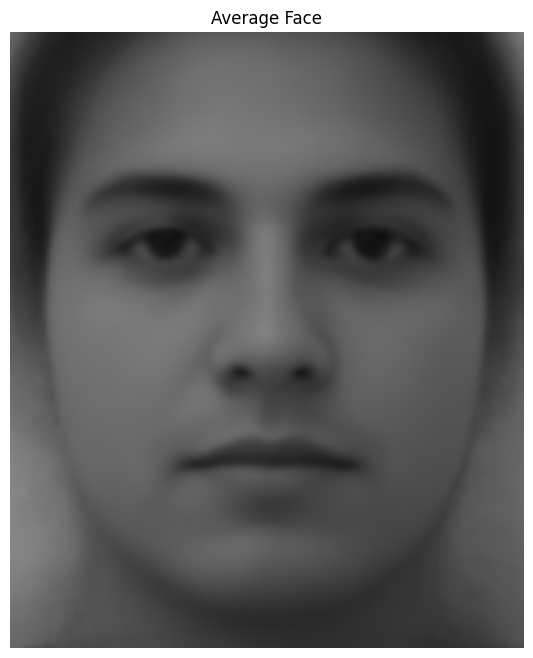

In [269]:
# Initialize the average face
height, width = warped_images[0].shape[:2]
average_face = np.zeros((height, width, 3), dtype=np.float32)

# Compute mean
for img in warped_images:
    average_face += img.astype(np.float32)

average_face /= len(warped_images)

average_face = np.clip(average_face, 0, 255).astype(np.uint8)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(average_face, cv2.COLOR_BGR2RGB))
plt.title('Average Face')
plt.axis('off')
plt.show()


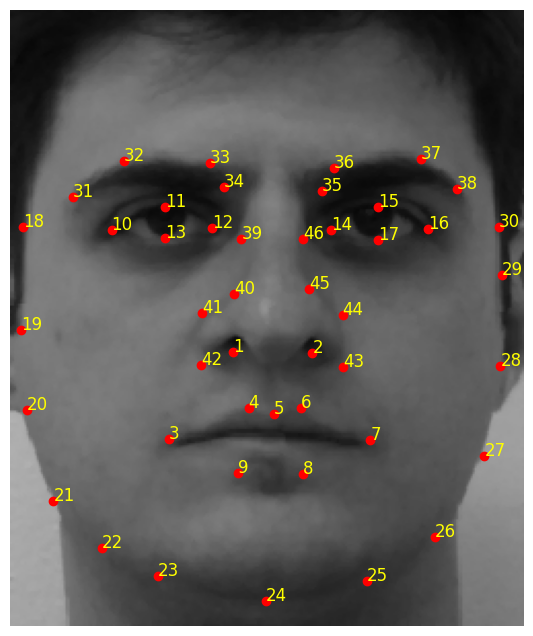

In [256]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def read_pts_file(pts_file_path):
    with open(pts_file_path, 'r') as f:
        lines = f.readlines()
    n_points_line = [line for line in lines if 'n_points' in line][0]
    n_points = int(n_points_line.strip().split(':')[1])
    start_idx = lines.index('{\n') + 1
    end_idx = start_idx + n_points
    points = []
    for line in lines[start_idx:end_idx]:
        x_str, y_str = line.strip().split()
        x, y = float(x_str), float(y_str)
        points.append([x, y])
    return np.array(points)

# Load an example image and keypoints to understand how it is labeled
image_path = 'FEI_frontal/1a.jpg'
pts_path = 'FEI_frontal/1a.pts'
img = cv2.imread(image_path)
points = read_pts_file(pts_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.scatter(points[:, 0], points[:, 1], color='red')

for i, (x, y) in enumerate(points):
    plt.text(x, y, str(i+1), color='yellow', fontsize=12)

plt.axis('off')
plt.show()


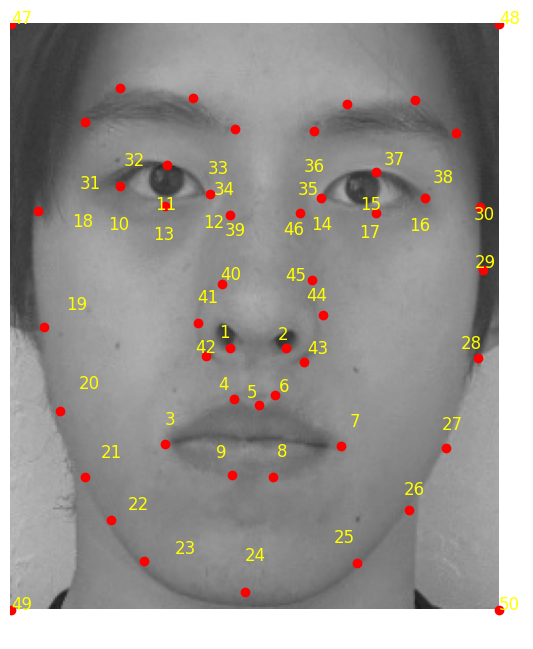

In [19]:
my_image = cv2.imread('me3.jpg')
my_points = [[112,166],[141,166],[79,215],[114,192],[127,195],[135,190],[169,216],[134,232],[113,231],[56,83],[80,72],[102,87],[79,93],[159,89],[187,76],[212,89],[187,97],[14,96],[17,155],[25,198],[38,232],[51,254],[68,275],[120,291],[177,276],[204,249],[223,217],[239,171],[242,126],[240,94],[38,50],[56,33],[93,38],[115,54],[155,55],[172,41],[207,39],[228,56],[112,98],[108,133],[96,153],[100,170],[150,173],[160,149],[154,131],[148,97]]

my_points.extend([[0, 0], [250, 0], [0, 300], [250, 300]])

my_points = np.array(my_points)

plt.figure(figsize=(8, 8))
plt.imshow(my_image)
plt.scatter(my_points[:, 0], my_points[:, 1], color='red')

for i, (x, y) in enumerate(points):
    plt.text(x, y, str(i+1), color='yellow', fontsize=12)

plt.axis('off')
plt.show()

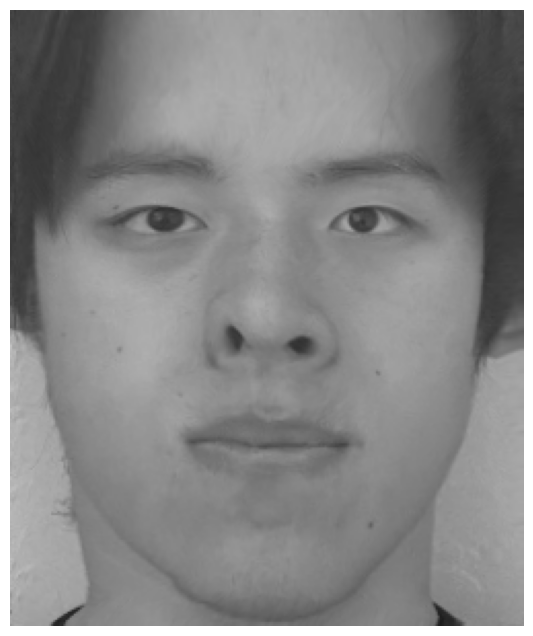

In [20]:
# Warp my face into the average shape
my_warped_face = warp_to_average_shape(my_image, my_points, mean_shape)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(my_warped_face, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



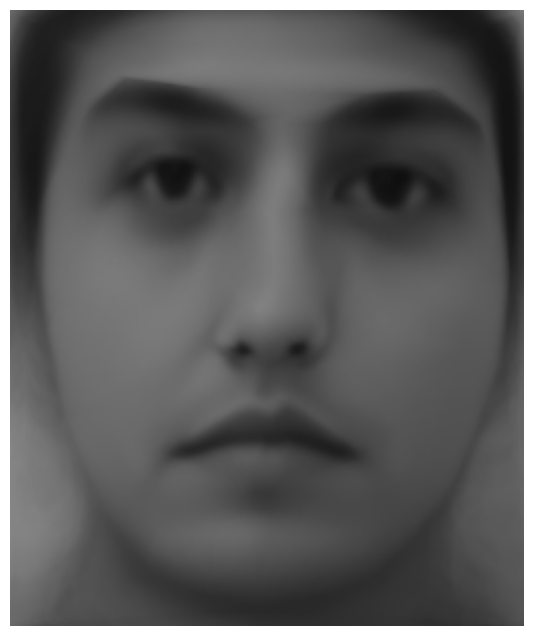

In [282]:
# Warp average face into my geometry
average_face_warped_to_me = warp_to_average_shape(average_face, mean_shape, my_points)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(average_face_warped_to_me, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


Part 5 -- Caricature: Extrapolating from the Mean

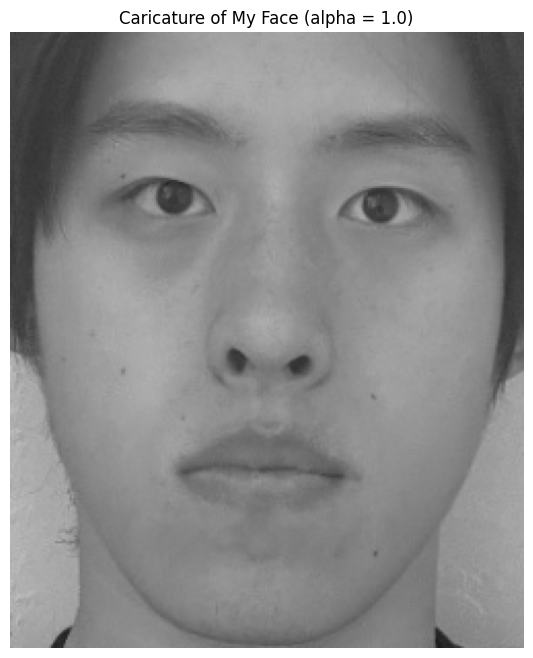

In [94]:
alpha = 1.0

caricature_points = mean_shape + alpha * (my_points - mean_shape)

caricature_image = warp_to_average_shape(my_image, my_points, caricature_points)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(caricature_image, cv2.COLOR_BGR2RGB))
plt.title(f'Caricature of My Face (alpha = {alpha})')
plt.axis('off')
plt.show()

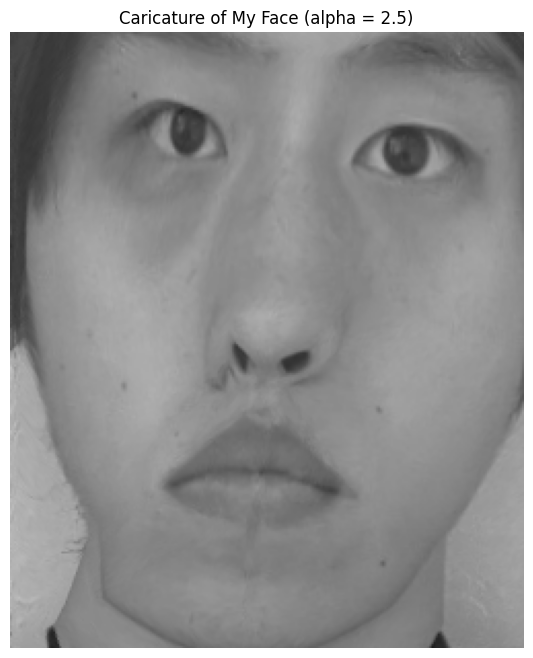

In [95]:
alpha = 2.5

caricature_points = mean_shape + alpha * (my_points - mean_shape)

caricature_image = warp_to_average_shape(my_image, my_points, caricature_points)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(caricature_image, cv2.COLOR_BGR2RGB))
plt.title(f'Caricature of My Face (alpha = {alpha})')
plt.axis('off')
plt.show()

PCA

In [127]:
grayscale_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in warped_images]

# Get Construct data matrix
height, width = grayscale_images[0].shape
num_pixels = height * width
num_images = len(grayscale_images)

data_matrix = np.zeros((num_images, num_pixels), dtype=np.float32)

for i, img in enumerate(grayscale_images):
    data_matrix[i, :] = img.flatten()


In [128]:
# Compute the mean face vector
mean_face_vector = np.mean(data_matrix, axis=0)

# Mean center data matrix
data_centered = data_matrix - mean_face_vector

# Compute the covariance matrix
covariance_matrix = np.dot(data_centered, data_centered.T) / num_images


In [129]:
# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors_temp = np.linalg.eigh(covariance_matrix)

# Sort eigenvectors by eigenvalues
sorted_indices = np.argsort(-eigenvalues)
eigenvalues = eigenvalues[sorted_indices]
eigenvectors_temp = eigenvectors_temp[:, sorted_indices]

# Compute normalized eigenvectors
eigenvectors = np.dot(data_centered.T, eigenvectors_temp)
eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=0)

In [130]:
num_components = 15

# Top components
eigenvectors_reduced = eigenvectors[:, :num_components]

# Project
pca_coefficients = np.dot(data_centered, eigenvectors_reduced)

In [131]:
my_warped_face_gray = cv2.cvtColor(my_warped_face, cv2.COLOR_BGR2GRAY)
my_face_vector = my_warped_face_gray.flatten().astype(np.float32)

# Mean center my face vector
my_face_vector_centered = my_face_vector - mean_face_vector

# Project onto PCA basis
my_pca_coefficients = np.dot(my_face_vector_centered, eigenvectors_reduced)

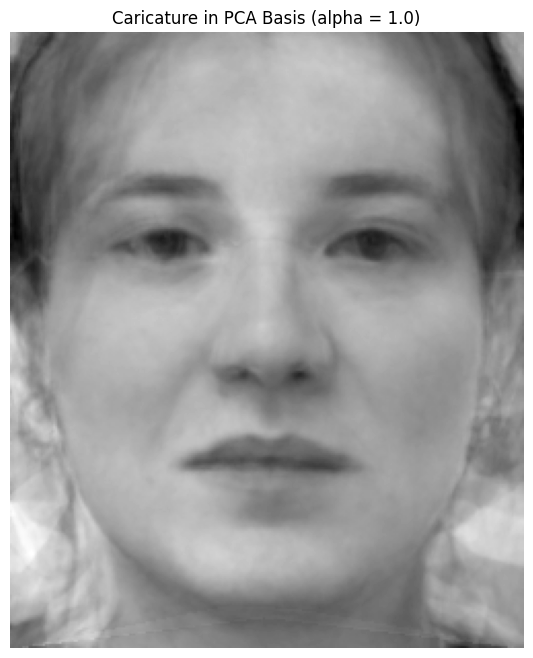

In [132]:
alpha = 1.0

caricature_coefficients_pca = alpha * my_pca_coefficients

caricature_face_vector_pca = np.dot(caricature_coefficients_pca, eigenvectors_reduced.T) + mean_face_vector

caricature_face_pca = caricature_face_vector_pca.reshape((height, width))

caricature_face_pca = np.clip(caricature_face_pca, 0, 255).astype(np.uint8)

plt.figure(figsize=(8, 8))
plt.imshow(caricature_face_pca, cmap='gray')
plt.title('Caricature in PCA Basis (alpha = {})'.format(alpha))
plt.axis('off')
plt.show()


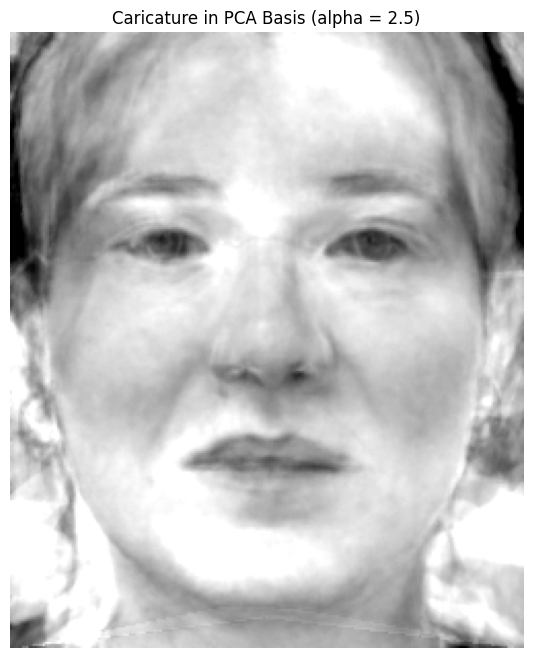

In [133]:
alpha = 2.5

caricature_coefficients_pca = alpha * my_pca_coefficients

caricature_face_vector_pca = np.dot(caricature_coefficients_pca, eigenvectors_reduced.T) + mean_face_vector

caricature_face_pca = caricature_face_vector_pca.reshape((height, width))

caricature_face_pca = np.clip(caricature_face_pca, 0, 255).astype(np.uint8)

plt.figure(figsize=(8, 8))
plt.imshow(caricature_face_pca, cmap='gray')
plt.title('Caricature in PCA Basis (alpha = {})'.format(alpha))
plt.axis('off')
plt.show()


Morph into average american female face

In [142]:
with open('keypoints2.json', 'r') as f:
    keypoints = json.load(f)

# Extract keypoints
im1_points = np.array(keypoints['im1Points'])
im2_points = np.array(keypoints['im2Points'])

corner_points = np.array([[0, 0], [600, 0], [0, 750], [600, 750]])

im1_points = np.vstack([im1_points, corner_points])
im2_points = np.vstack([im2_points, corner_points])

# Load images
im1 = cv2.imread('me.jpg')
im2 = cv2.imread('mean.jpg')

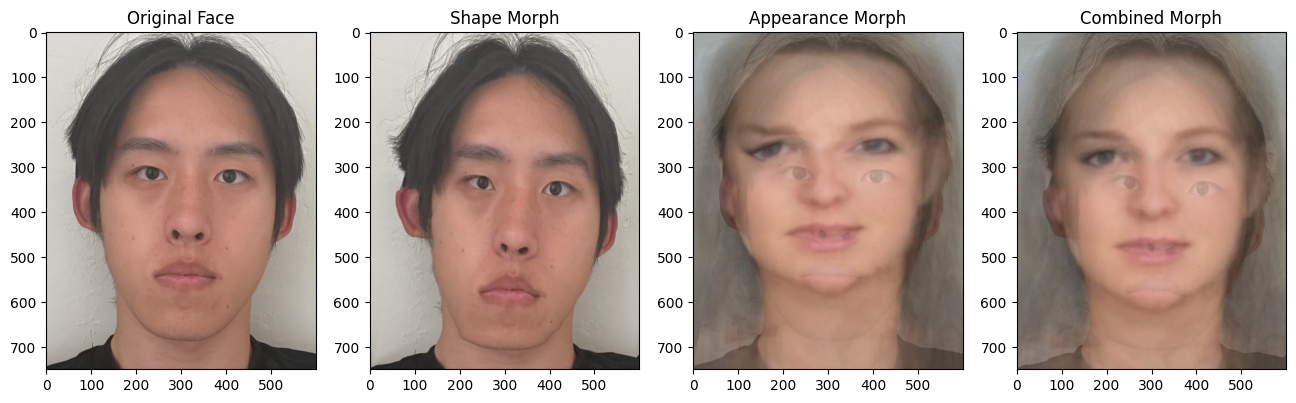

In [147]:
#Same as first midway image
average_points = (im1_points + im2_points) / 2

tri = Delaunay(average_points)

# Shape morphing
morphed_shape = morph_faces(im1, im2, im1_points, im2_points, average_points, tri, warp_frac=0.7, dissolve_frac=0.0)

# Appearance morphing
morphed_appearance = morph_faces(im1, im2, im1_points, im2_points, average_points, tri, warp_frac=0.0, dissolve_frac=0.7)

# Combined morphing
morphed_combined = morph_faces(im1, im2, im1_points, im2_points, average_points, tri, warp_frac=0.7, dissolve_frac=0.7)

plt.figure(figsize=(16, 8))

plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
plt.title('Original Face')

plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(morphed_shape, cv2.COLOR_BGR2RGB))
plt.title('Shape Morph')

plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(morphed_appearance, cv2.COLOR_BGR2RGB))
plt.title('Appearance Morph')

plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(morphed_combined, cv2.COLOR_BGR2RGB))
plt.title('Combined Morph')

plt.show()

In [148]:
import imageio

num_frames = 45
frames = []

for i in range(num_frames):
    frac = i / (num_frames - 1)

    intermediate_points = (1 - frac) * im1_points + frac * im2_points

    tri = Delaunay(intermediate_points)

    morphed_im = morph_faces(im1, im2, im1_points, im2_points, intermediate_points, tri, warp_frac=frac, dissolve_frac=frac)

    frames.append(cv2.cvtColor(morphed_im, cv2.COLOR_BGR2RGB))

imageio.mimsave('morph_sequence2.gif', frames, fps=10)
